# Test differentiatiors

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
import seaborn as sns

import pysindy as ps

In [ ]:
diffs = [
    ('Spectral', ps.SpectralDifferentiator()),
    ('Spline', ps.SplineDifferentiator(s=1e-2)),
    ('Trend Filtered', ps.TrendFilteredDifferentiator(order=0, alpha=1e-2)),
    ('Finite Difference', ps.FiniteDifferenceDifferentiator(k=1)),
    ('PySINDy Finite Difference', ps.FiniteDifference()),
    ('Savitzky Golay', ps.SavitzkyGolayDifferentiator(left=0.5, right=0.5, order=3)),
    ('PySINDy Savgol', ps.SmoothedFiniteDifference()),
]

plot_kws = dict(alpha=0.7, linewidth=3)

## Compare differentiation methods directly

In [13]:
noise_level = 0.01

In [7]:
def compare_methods(diffs, x, y, y_noisy, y_dot):
    n_methods = len(diffs)
    n_rows = (n_methods // 3) + int(n_methods % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for (name, method), ax in zip(diffs, axs.flatten()):
        ax.plot(x, y_dot, label='Exact', color=pal[0], **plot_kws)
        ax.plot(x, method(y, x), ':', label='Approx.', color='black', **plot_kws)
        ax.plot(x, method(y_noisy, x), label='Noisy.', color=pal[1], **plot_kws)
        ax.set(title=name)

    axs[0, 0].legend()
    fig.show()
    
    return axs

### Sine

/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004372207567003343, tolerance: 0.0042094533933600175
  positive)


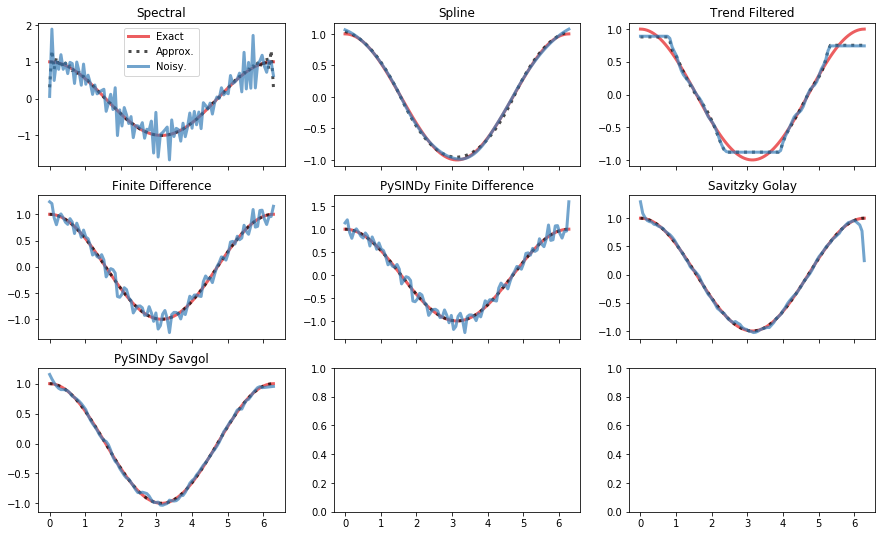

In [12]:
# True data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)
y_dot = np.cos(x)

# Add noise
seed = 111
np.random.seed(seed)
y_noisy = y + noise_level * np.random.randn(len(y))

axs = compare_methods(diffs, x, y, y_noisy, y_dot)

### Absolute value

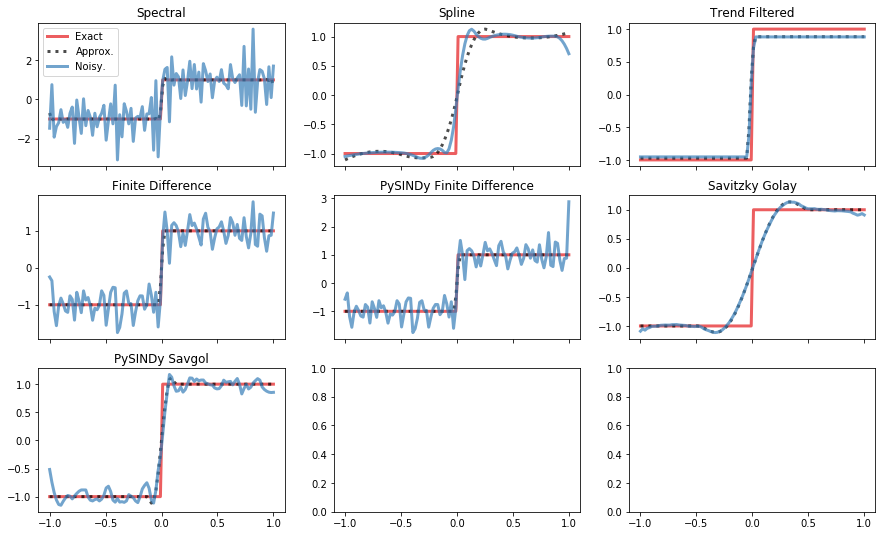

In [15]:
# True data
x = np.linspace(-1, 1, 100)
y = np.abs(x)
y_dot = np.sign(x)

# Add noise
seed = 111
np.random.seed(seed)
y_noisy = y + noise_level * np.random.randn(len(y))

axs = compare_methods(diffs, x, y, y_noisy, y_dot)

## Compare when used in PySINDy

In [57]:
noise_level = 0.1

In [46]:
def print_equations(equations_clean, equations_noisy):
    print(f"{'':<30} {'Noiseless':<40} {'Noisy':<40}")
    
    for name in equations_clean.keys():
        print(f"{name:<30} {'':<40} {'':<40}")

        for k, (eq1, eq2) in enumerate(zip(equations_clean[name], equations_noisy[name])):
            print(f"{'':<30} {'x' + str(k) + '=' + str(eq1):<40} {'x' + str(k) + '=' + str(eq2):<40}")

### Linear oscillator
$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [60]:
# Generate training data
def f(x, t):
    return [
        -0.1 * x[0] + 2 * x[1],
        -2 * x[0] - 0.1 * x[1]        
    ]


dt = 0.01
t_train = np.arange(0, 10, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

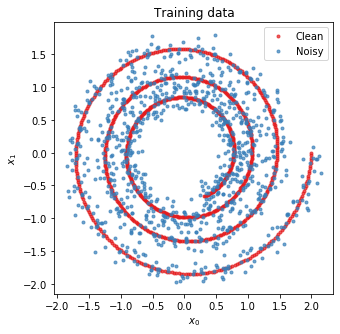

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(x_train[:, 0], x_train[:, 1], '.', label="Clean", color=pal[0], **plot_kws)
ax.plot(x_train_noisy[:, 0], x_train_noisy[:, 1], '.', label="Noisy", color=pal[1], **plot_kws)

ax.set(title='Training data', xlabel='$x_0$', ylabel='$x_1$')
ax.legend()
fig.show()

In [64]:
equations_clean = {}
equations_noisy = {}
threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt
    )
    
    model.fit(x_train)
    equations_clean[name] = model.equations()
    
    model.fit(x_train_noisy)
    equations_noisy[name] = model.equations()

/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.696257012046825, tolerance: 0.18904536465857827
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.896199890455174, tolerance: 0.08560248874992059
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.451701327870975, tolerance: 0.19880591392040625
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

In [65]:
print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
Spectral                                                                                                        
                               x0=1.941 x1                              x0=1.896 x1                             
                               x1=-1.902 x0                             x1=-1.828 x0                            
Spline                                                                                                          
                               x0=2.006 x1                              x0=1.954 x1                             
                               x1=-1.996 x0                             x1=-1.796 x0                            
Trend Filtered                                                                                                  
                               x0=1.906 x1                              x0=1.902 x1             

### Lorenz system

$$ \begin{aligned} \dot x &= 10(y-x)\\ \dot y &= x(28 - z) - y \\ \dot z &= xy - \tfrac{8}{3} z, \end{aligned} $$


In [69]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_train_noisy = x_train + noise_level * np.random.randn(*x_train.shape)

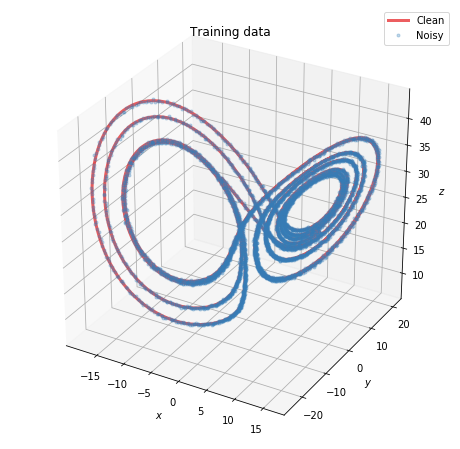

In [81]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot(
    x_train[:, 0],
    x_train[:, 1],
    x_train[:, 2],
    color=pal[0],
    label='Clean',
    **plot_kws
)

ax.plot(
    x_train_noisy[:, 0],
    x_train_noisy[:, 1],
    x_train_noisy[:, 2],
    '.',
    color=pal[1],
    label='Noisy',
    alpha=0.3,
)
ax.set(title='Training data', xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()
fig.show()

In [83]:
equations_clean = {}
equations_noisy = {}
threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt
    )
    
    model.fit(x_train)
    equations_clean[name] = model.equations()
    
    model.fit(x_train_noisy)
    equations_noisy[name] = model.equations()

/home2/bdesilva/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:513: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61050.36685322848, tolerance: 40.05596600277293
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100723.94546549318, tolerance: 40.30924661091584
  positive)
/home2/bdesilva/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not conv

In [84]:
print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
Spectral                                                                                                        
                               x0=-1.683 1 + -9.076 x0 + 9.148 x1       x0=-1.697 1 + -9.090 x0 + 9.164 x1      
                               x1=28.810 x0 + -1.370 x1 + -1.015 x0 x2  x1=28.522 x0 + -1.275 x1 + -1.009 x0 x2 
                               x2=86.506 1 + -7.285 x2 + 1.365 x0^2     x2=86.436 1 + -7.282 x2 + 1.365 x0^2    
Spline                                                                                                          
                               x0=-10.000 x0 + 10.000 x1                x0=-9.969 x0 + 9.975 x1                 
                               x1=28.003 x0 + -1.001 x1 + -1.000 x0 x2  x1=27.828 x0 + -0.960 x1 + -0.996 x0 x2 
                               x2=-2.667 x2 + 1.000 x0 x1               x2=-2542.189 1 + -155.18